In [2]:
import os
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.models import load_model


2024-12-11 08:23:02.071227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
VAL_IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "val")
VAL_LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "val")

# Constants
LIMIT_IMAGES = 10 # Number of images to sample
MAX_PIXELS = 10000  # Max number of pixels to process
LABEL_ID = 7  # Road label
BATCH_SIZE = 32 # Patch size
TARGET_SIZE = 256 # size of resample image width


In [4]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [5]:
def load_images_from_folder(images_dir, labels_dir):
    image_paths = []
    label_paths = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"): 
            image_paths.append(os.path.join(images_dir, filename))
            label_paths.append(os.path.join(labels_dir, filename.replace("leftImg8bit", "gtFine").replace(".png", "_label.png")))
    
    return image_paths, label_paths

In [6]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [7]:
import cv2
import numpy as np
import os
import tqdm

def image_label_generator(image_label_pairs, target_size=TARGET_SIZE, label_id=LABEL_ID, batch_size=BATCH_SIZE):
    """
    A generator that yields batches of resized images and their corresponding labels for training.

    Args:
        image_label_pairs: List of (image_path, label_path) tuples.
        TARGET_SIZE: Fixed width for resizing images, height will be calculated based on the aspect ratio.
        label_id: The label ID for the target class (e.g., road class in segmentation).
        batch_size: Number of samples to return in each batch.

    Yields:
        A tuple (X_batch, y_batch), where X_batch is a batch of images and y_batch is the corresponding batch of labels.
    """
    while True:  # Keep generating images indefinitely
        X_batch = []  # List to store images in the current batch
        y_batch = []  # List to store labels in the current batch
        
        for image_path, label_path in tqdm.tqdm(image_label_pairs):
            # Read and resize the image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            h, w = image.shape[:2]

            # Calculate new height based on aspect ratio
            target_height = int((target_size / w) * h)

            # Resize the image
            image_resized = cv2.resize(image, (target_size, target_height))
            X_batch.append(image_resized)

            # Read and resize the label image
            label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            label_resized = cv2.resize(label_img, (target_size, target_height), interpolation=cv2.INTER_NEAREST)

            # Convert label to binary mask (for the target class)
            binary_label = (label_resized == label_id).astype(np.uint8)
            y_batch.append(binary_label)

            # If the batch size is met, yield the batch and reset the batch lists
            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)
                X_batch = []
                y_batch = []

        # If any remaining samples in the batch (less than batch_size), yield them
        if len(X_batch) > 0:
            yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)


In [8]:
def extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE):
    
    # Get training and validation image-label pairs
    train_image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
    val_image_label_pairs = get_image_label_pairs(VAL_IMAGES_DIR, VAL_LABELS_DIR)

    # Create generators for both training and validation data
    train_generator = image_label_generator(
        train_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )
    
    val_generator = image_label_generator(
        val_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )

    # This will just return the generators as we will use them for training
    return train_generator, val_generator


In [9]:
STEPS_PER_EPOCH = 1000

train_generator, val_generator = extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

In [10]:
from tensorflow.keras import layers, models

def build_fcn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Feature Extraction)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample

    # Decoder (Upsampling)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)  # Upsample

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax' if num_classes > 1 else 'sigmoid')(x)

    # Model
    model = models.Model(inputs, outputs)
    return model


In [12]:
model = load_model('model_fcn.keras')

In [13]:
from tensorflow.keras import optimizers, callbacks

# Assuming `build_fcn` is a function that builds your FCN model.
# Make sure you have this function implemented somewhere in your code.

def train_image_classifier_with_generator(train_generator, val_generator, steps_per_epoch, validation_steps, epochs=20, batch_size=32):
    # Build the full-image classifier
    input_shape = (128, 256, 3)  # Adjust as per your image dimensions (example size)
    model = build_fcn(input_shape, num_classes=1) 

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
        metrics=['accuracy']
    )

    # Define callbacks
    checkpoint_cb = callbacks.ModelCheckpoint("image_classifier_best.keras", save_best_only=True, monitor="val_loss", mode="min")
    early_stopping_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss", mode="min")

    # Train the model using the generators
    history = model.fit(
        train_generator, 
        steps_per_epoch=steps_per_epoch,  # Number of steps per epoch (e.g., len(train_image_label_pairs) // batch_size)
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,  # Number of steps for validation (similar to steps_per_epoch)
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )

    return model, history

# Example usage:
epochs = 20
batch_size = 32
steps_per_epoch = 1000  # Adjust this based on your dataset size and batch size
validation_steps = 100  # Same as steps_per_epoch for validation, adjust as needed

# Assuming train_generator and val_generator are defined and working with your image-label pairs
# model, history = train_image_classifier_with_generator(
#     train_generator, 
#     val_generator, 
#     steps_per_epoch=steps_per_epoch, 
#     validation_steps=validation_steps, 
#     epochs=epochs, 
#     batch_size=batch_size
# )

# Check the model summary after training
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 32, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 64, 128, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 128, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,365 (3.81 MB)

 Trainable params: 333,121 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 666,244 (2.54 MB)

In [ ]:
#model.save('model_fcn.keras')

In [15]:
# make the plot of the loss and accuracy
def plot_loss_accuracy(history):
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_loss_accuracy(history)

NameError: name 'history' is not defined

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.43it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


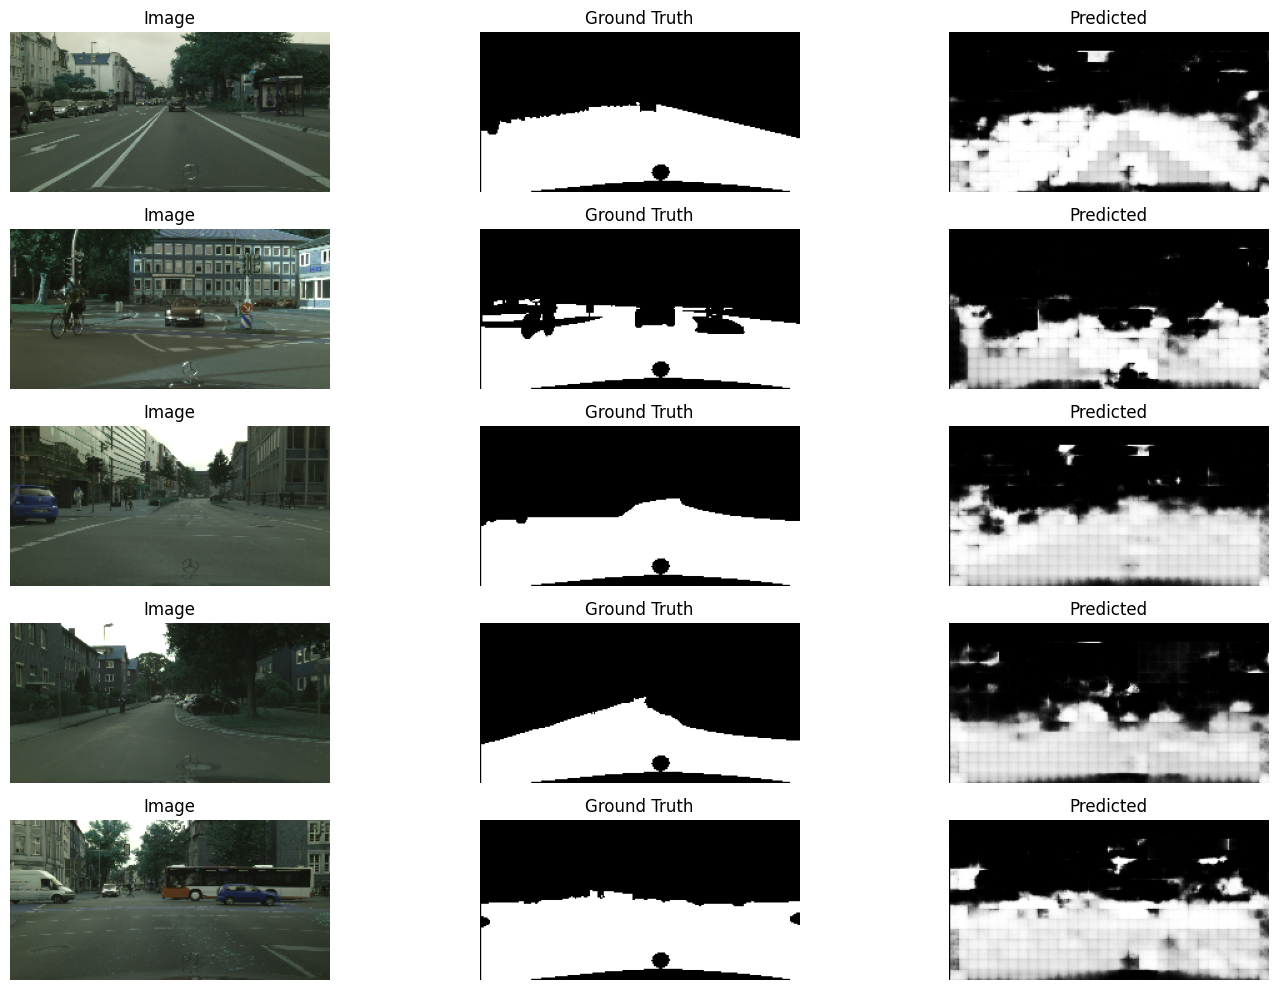

In [ ]:
# geenrate the x_val from the genertaor funciotn, a good amoint of data to test the model
X_val, y_val = next(val_generator)

# Predict on the validation data
y_pred = model.predict(X_val)

def plot_images(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(X[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Predicted")

    plt.tight_layout()
    plt.show()

plot_images(X_val, y_val, y_pred)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
X_val, y_val = next(val_generator)

# Predict on the validation data
y_pred = model.predict(X_val)
y_pred = model.predict(X_val)

y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


ValueError: unknown is not supported

In [22]:
y_pred.shape

(10, 128, 256, 1)

In [24]:
y_val.shape

(10, 128, 256, 1)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
# Flatten the arrays
y_pred_flat = y_pred.ravel()
y_val_flat = y_val.ravel()

# Compute the confusion matrix
cm = confusion_matrix(y_val_flat, y_pred_flat)

# Print classification report
print(classification_report(y_val_flat, y_pred_flat))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


ValueError: Classification metrics can't handle a mix of binary and continuous targets